In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
dados = np.load("/content/mimic_X_y_mask_10j_2h_bal.npz")

# Extraindo os arrays
X_bal = dados["X"]
y_bal = dados["y"]
mask_bal = dados["mask"]

print("Dados carregados da versão balanceada")
print(f"Total de amostras: {len(y_bal)}")
print(f"Com Sepse: {np.sum(y_bal == 1)}")
print(f"Sem Sepse: {np.sum(y_bal == 0)}")

Dados carregados da versão balanceada
Total de amostras: 14124
Com Sepse: 7062
Sem Sepse: 7062


In [3]:
# Divisão treino + temp (validação+teste)
X_train, X_temp, y_train, y_temp, mask_train, mask_temp = train_test_split(
    X_bal, y_bal, mask_bal, test_size=0.30, random_state=42, stratify=y_bal
)

# Divisão temp => validação e teste (50/50% de 30%)
X_val, X_test, y_val, y_test, mask_val, mask_test = train_test_split(
    X_temp, y_temp, mask_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Forma da entrada
input_shape = X_train.shape[1:]

# Definição do modelo LSTM
inputs = tf.keras.Input(shape=input_shape)
x = layers.Masking(mask_value=0.0)(inputs)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

# Compilar o modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinamento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - accuracy: 0.5583 - auc: 0.5847 - loss: 0.7447 - precision: 0.5673 - recall: 0.3990 - val_accuracy: 0.6843 - val_auc: 0.7517 - val_loss: 0.6562 - val_precision: 0.6517 - val_recall: 0.7925
Epoch 2/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.6935 - auc: 0.7394 - loss: 0.6525 - precision: 0.6931 - recall: 0.6979 - val_accuracy: 0.7088 - val_auc: 0.7561 - val_loss: 0.6323 - val_precision: 0.7027 - val_recall: 0.7245
Epoch 3/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7076 - auc: 0.7523 - loss: 0.6337 - precision: 0.7168 - recall: 0.6812 - val_accuracy: 0.7098 - val_auc: 0.7562 - val_loss: 0.6270 - val_precision: 0.7070 - val_recall: 0.7170
Epoch 4/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7031 - auc: 0.7519 - loss: 0.6282 - precision: 0.7112 - recall: 0.6823 - val_accuracy: 0.7060 - val_auc: 0.7576 - val_loss: 0.6213 - val_precision: 0.6960 - val_recall: 0.7321
Epoch 5/100
309/309 

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Acurácia: 0.6857
AUC: 0.4909
Precisão: 0.5015
Recall: 0.4736
F1-score: 0.4871


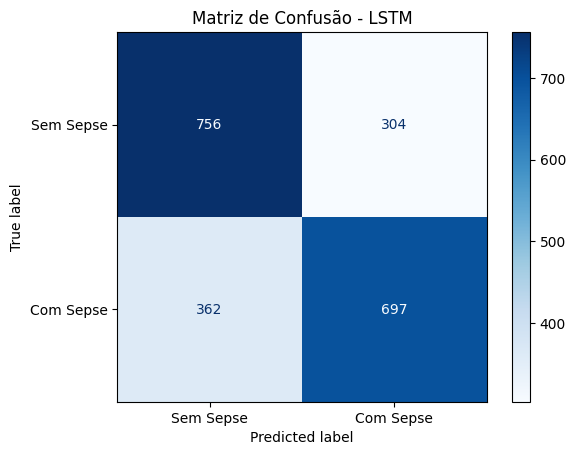

In [4]:
# Previsão das probabilidades
y_pred_prob = model.predict(X_test).flatten()

# Limiar de classificação
limiar = 0.5
y_pred = (y_pred_prob >= limiar).astype(int)

from sklearn.metrics import accuracy_score;
# Cálculo das métricas
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_val, y_pred_prob):.4f}")
print(f"Precisão: {precision_score(y_val, y_pred):.4f}")
print(f"Recall: {recall_score(y_val, y_pred):.4f}")
print(f"F1-score: {f1_score(y_val, y_pred):.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sem Sepse", "Com Sepse"])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão - LSTM")
plt.show()

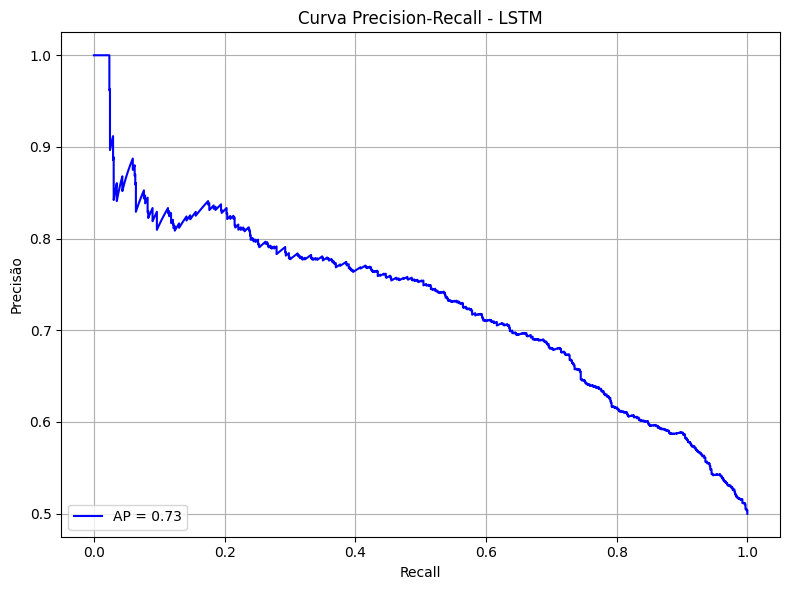

In [5]:
# Curva Precision-Recall com dados de teste
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
ap_score = average_precision_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"AP = {ap_score:.2f}", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precisão")
plt.title("Curva Precision-Recall - LSTM")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()